In [1]:
import hydra
from omegaconf import OmegaConf

hydra.initialize(config_path="../configs")

# Load the config file
cfg = hydra.compose(config_name="config")

# # Print config as YAML
# config = OmegaConf.to_yaml(cfg)
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

# Now, you can import the module
import diffusion

import utils
import math

cfg.eval.checkpoint_path = '/nfs/mtr/code/ddit-c2i/outputs/ddit-gitmodel-linear-bs1024/03-01-045328/checkpoints/30-380000.ckpt'
cfg.mask_vocab_size = 1
cfg.lm_vocab_size = 16384
cfg.mode = 'eval'


def _load_from_checkpoint(config):
    
    return diffusion.Diffusion.load_from_checkpoint(
        config.eval.checkpoint_path,
        config=config,
        strict=False)


model = _load_from_checkpoint(config=cfg)
model = model.to('cuda:0')
for p in model.parameters():
    p.requires_grad = False

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import torch


/tmp/ipykernel_712236/4113921923.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="../configs")
/root/miniconda3/envs/mdm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/mdm/lib/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

Current state = eval, set to eval mode.
RepA disabled or abandoned, please notice it.


/root/miniconda3/envs/mdm/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:184: Found keys that are in the model state dict but not in the checkpoint: ['backbone.blocks.0.mlp.fc1.weight', 'backbone.blocks.0.mlp.fc1.bias', 'backbone.blocks.0.mlp.fc2.weight', 'backbone.blocks.0.mlp.fc2.bias', 'backbone.blocks.1.mlp.fc1.weight', 'backbone.blocks.1.mlp.fc1.bias', 'backbone.blocks.1.mlp.fc2.weight', 'backbone.blocks.1.mlp.fc2.bias', 'backbone.blocks.2.mlp.fc1.weight', 'backbone.blocks.2.mlp.fc1.bias', 'backbone.blocks.2.mlp.fc2.weight', 'backbone.blocks.2.mlp.fc2.bias', 'backbone.blocks.3.mlp.fc1.weight', 'backbone.blocks.3.mlp.fc1.bias', 'backbone.blocks.3.mlp.fc2.weight', 'backbone.blocks.3.mlp.fc2.bias', 'backbone.blocks.4.mlp.fc1.weight', 'backbone.blocks.4.mlp.fc1.bias', 'backbone.blocks.4.mlp.fc2.weight', 'backbone.blocks.4.mlp.fc2.bias', 'backbone.blocks.5.mlp.fc1.weight', 'backbone.blocks.5.mlp.fc1.bias', 'backbone.blocks.5.mlp.fc2.weight', 'backbone.blocks.5.mlp.fc2.bi

In [ ]:
# def generate_clustered_points(num_points=100, num_clusters=100, embedding_dim=768, cluster_std=5.0):
#     """Generate synthetic data with clusters in a high-dimensional space."""
#     np.random.seed(42)
#     cluster_centers = np.random.randn(num_clusters, embedding_dim) * 20  # Spread out clusters
#     points = []
#     for _ in range(num_points):
#         cluster = np.random.randint(0, num_clusters)
#         point = cluster_centers[cluster] + np.random.randn(embedding_dim) * cluster_std
#         points.append(point)
#     return np.array(points)

# points = generate_clustered_points()

In [2]:
num_tokens = 16384 + 1
embeddings = model.backbone.vocab_embed(np.arange(num_tokens))  # Shape: (17408, embedding_dim)
embeddings = embeddings.cpu().float().numpy()
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
reduced_embeddings = tsne.fit_transform(embeddings)


In [4]:
reduced_embeddings

array([[ 3.779684  , 28.445175  ],
       [15.055959  , -5.605056  ],
       [ 7.949875  , -8.850643  ],
       ...,
       [ 6.6124606 , 63.804504  ],
       [ 4.4880404 , 61.01683   ],
       [ 0.48262525, 60.46104   ]], dtype=float32)

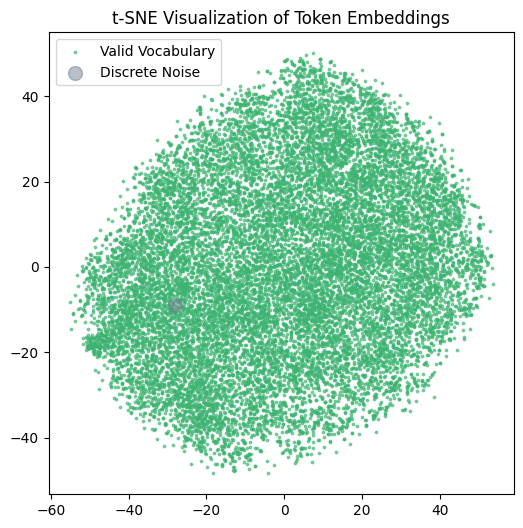

In [3]:
# Apply t-SNE for visualization
plt.figure(figsize=(6, 6))
plt.scatter(reduced_embeddings[:16384, 0], reduced_embeddings[:16384, 1], s=3, alpha=0.6, color='mediumseagreen', label='Valid Vocabulary')
plt.scatter(reduced_embeddings[16384:, 0], reduced_embeddings[16384:, 1], s=100, alpha=0.5, color='slategray', label='Discrete Noise')
plt.legend()
plt.title("t-SNE Visualization of Token Embeddings")
plt.show()

In [4]:
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=50)
reduced_embeddings_3d = tsne_3d.fit_transform(embeddings)


In [33]:
reduced_embeddings_3d.shape

(17408, 3)

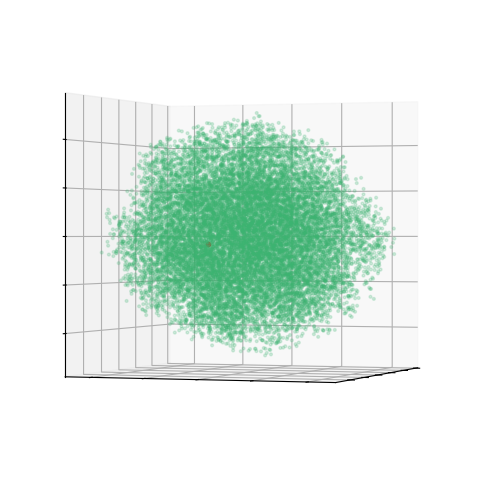

In [25]:

# Plot first 16384 tokens in blue, last 1024 tokens in red
fig_3d = plt.figure(figsize=(6, 6))
ax = fig_3d.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])  # X:Y:Z ratio
ax.scatter(reduced_embeddings_3d[:16384, 0], reduced_embeddings_3d[:16384, 1], reduced_embeddings_3d[:16384, 2], s=4, alpha=0.2, color='mediumseagreen', label='Valid Vocabulary')
ax.scatter(reduced_embeddings_3d[16384:, 0], reduced_embeddings_3d[16384:, 1], reduced_embeddings_3d[16384:, 2], s=10, alpha=1, color='red', label='Discrete Noise')
# ax.set_title("t-SNE 3D Visualization of Token Embeddings")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_ylim(-50,50)
ax.axes.zaxis.set_ticklabels([])
# ax.view_init(elev=0, azim=20) # for 1024 0,20
ax.view_init(elev=0, azim=20) # for 1024 0,20
# ax.legend()
plt.show()